<a href="https://colab.research.google.com/github/seungyihong/dacon_AI_Frenz/blob/master/temperature_estimation7(3_3597)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!pip install tensorflow==2.1.0

In [0]:
#!pip install --upgrade tensorflow

In [0]:
#!pip install tensorflow-gpu

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import tensorflow as tf
import os
import pickle
import warnings 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import style


warnings.filterwarnings('ignore')
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
print(tf.__version__)
print(tf.test.is_gpu_available())

2.2.0-rc3
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [0]:
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [0]:
os.chdir('/content/drive/My Drive/Dacon/온도 추정')

# 데이터 로드 및 데이터 확인




> 데이터 설명 

모든 데이터는 시간순으로 정렬되어있으며, 10분 단위로 측정됨

*   train 데이터 


1.   X00 ~ X39 : 5개의 지역에 대해 8가지씩 속성 칼럼 (관측소 데이터) ( 30일 + 3일 )
2.   Y00 ~ Y17 : 센서로 온도 측정
( 30일 o , 3일 x )

3. Y18 : 예측 센서 ( 30일 x, 3일 o)

*   test 데이터

1.  X00 ~ X39 : 80일간 관측한 8가지 속성에대한 5개 지역의 관측소 데이터



## 기본적인 데이터 정보 확인


In [0]:
train = pd.read_csv('/content/drive/My Drive/Dacon/온도 추정/input/train.csv', index_col = 'id')
test = pd.read_csv('/content/drive/My Drive/Dacon/온도 추정/input/test.csv',index_col = 'id')
train0 = pd.read_csv('/content/drive/My Drive/Dacon/온도 추정/input/train.csv')

In [0]:
all_data = pd.concat([train.loc[:,'X00':'X39'],test], sort = False)

In [0]:
train.columns

Index(['X00', 'X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29',
       'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39',
       'Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09',
       'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18'],
      dtype='object')

In [0]:
test.columns

Index(['X00', 'X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29',
       'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39'],
      dtype='object')

In [0]:
train.head()

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.0,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.0,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.0,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.0,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.0,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.0,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.0,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.0,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN


In [0]:
train.shape

(4752, 59)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4752 entries, 0 to 4751
Data columns (total 59 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X00     4752 non-null   float64
 1   X01     4752 non-null   float64
 2   X02     4752 non-null   float64
 3   X03     4752 non-null   float64
 4   X04     4752 non-null   float64
 5   X05     4752 non-null   float64
 6   X06     4752 non-null   float64
 7   X07     4752 non-null   float64
 8   X08     4752 non-null   float64
 9   X09     4752 non-null   float64
 10  X10     4752 non-null   float64
 11  X11     4752 non-null   float64
 12  X12     4752 non-null   float64
 13  X13     4752 non-null   float64
 14  X14     4752 non-null   float64
 15  X15     4752 non-null   float64
 16  X16     4752 non-null   float64
 17  X17     4752 non-null   float64
 18  X18     4752 non-null   float64
 19  X19     4752 non-null   float64
 20  X20     4752 non-null   float64
 21  X21     4752 non-null   float64
 22  

In [0]:
test.head()

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4752,18.7,987.4,1.5,1.3,0.0,1006.8,987.7,21.1,1007.5,1007.2,0.0,0.0,96.1,333.6,0.0,199.6,0.0,36.0,1.1,0.0,94.7,0.0,1000.3,1007.6,0.0,0.0,0.1,1006.0,23.2,999.5,91.4,17.5,19.2,1007.6,0.0,194.7,0.0,84.0,59.9,0.0
4753,18.8,987.4,1.1,1.2,0.0,1006.7,987.7,21.2,1007.5,1007.2,0.0,0.0,96.2,335.5,0.0,194.0,0.0,127.7,0.6,0.0,95.3,0.0,1000.2,1007.5,0.0,0.0,0.3,1005.9,23.1,999.4,91.6,17.4,19.1,1007.5,0.0,173.1,0.0,84.0,60.5,0.0
4754,19.0,987.4,1.3,1.2,0.0,1006.6,987.6,21.2,1007.4,1007.2,0.0,0.0,96.4,0.0,0.0,172.9,0.0,59.0,0.0,0.0,93.9,0.0,1000.1,1007.4,0.0,0.0,0.7,1005.9,23.1,999.3,92.0,17.2,19.0,1007.5,0.0,208.6,0.0,85.0,60.8,0.0
4755,18.7,987.4,2.3,0.8,0.0,1006.6,987.6,21.1,1007.4,1007.2,0.0,0.0,96.5,252.9,0.0,153.5,0.0,54.9,0.4,0.0,94.4,0.0,1000.1,1007.4,0.0,0.0,0.6,1005.8,22.8,999.3,93.0,17.2,18.8,1007.4,0.0,185.0,0.0,85.8,61.2,0.0
4756,18.4,987.4,1.1,0.7,0.0,1006.7,987.7,20.9,1007.5,1007.2,0.0,0.0,96.6,238.2,0.0,173.8,0.0,48.8,0.8,0.0,95.7,0.0,1000.2,1007.3,0.0,0.0,0.7,1005.9,22.8,999.2,92.3,17.4,18.9,1007.5,0.0,162.8,0.0,87.3,61.7,0.0


In [0]:
test.shape

(11520, 40)

In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11520 entries, 4752 to 16271
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X00     11520 non-null  float64
 1   X01     11520 non-null  float64
 2   X02     11520 non-null  float64
 3   X03     11520 non-null  float64
 4   X04     11520 non-null  float64
 5   X05     11520 non-null  float64
 6   X06     11520 non-null  float64
 7   X07     11520 non-null  float64
 8   X08     11520 non-null  float64
 9   X09     11520 non-null  float64
 10  X10     11520 non-null  float64
 11  X11     11520 non-null  float64
 12  X12     11520 non-null  float64
 13  X13     11520 non-null  float64
 14  X14     11520 non-null  float64
 15  X15     11520 non-null  float64
 16  X16     11520 non-null  float64
 17  X17     11520 non-null  float64
 18  X18     11520 non-null  float64
 19  X19     11520 non-null  float64
 20  X20     11520 non-null  float64
 21  X21     11520 non-null  float64


## 주요 속성 살펴보기(X00~X39)

In [0]:
# 데이터 정보
temperature_name = ["X00","X07","X28","X31","X32"] #기온
localpress_name  = ["X01","X06","X22","X27","X29"] #현지기압
speed_name       = ["X02","X03","X18","X24","X26"] #풍속
water_name       = ["X04","X10","X21","X36","X39"] #일일 누적강수량
press_name       = ["X05","X08","X09","X23","X33"] #해면기압
sun_name         = ["X11","X14","X16","X19","X34"] #일일 누적일사량 - sun으로 대체
humidity_name    = ["X12","X20","X30","X37","X38"] #습도
direction_name   = ["X13","X15","X17","X25","X35"] #풍향
press_sum_name = ["X01","X06","X22","X27","X29","X05","X08","X09","X23","X33"]
x_columns = [temperature_name, localpress_name, speed_name, water_name, press_name, sun_name, humidity_name, direction_name]

In [0]:
def show_plot(col_group):
    plt.plot(all_data[col_group])
    plt.show()
    sns.boxplot(x='variable', y='value', data=pd.melt(all_data[col_group]))
    plt.show()

In [0]:
def kde_plot(col_group):
    for col in col_group:
        sns.kdeplot(all_data[col], kernel='epa')
    plt.show()

###X00~ X39 Plot

In [0]:
#컬럼에 대한 기초통계량 확인 (행별 계산)
for i in x_columns:
  print(i)
  print(train[i].describe())

#요소를 인덱스별로 합쳐서 하나의 컬럼으로 생성!  (열별 계산)
#pd.Series(train[temperature_name].mean(axis = 1))

['X00', 'X07', 'X28', 'X31', 'X32']
               X00          X07          X28          X31          X32
count  4752.000000  4752.000000  4752.000000  4752.000000  4752.000000
mean     20.227904    21.658081    22.079040    19.846528    20.012984
std       4.707570     4.377216     4.225203     5.520259     5.271630
min       8.300000    11.600000    10.300000     5.300000     5.500000
25%      16.900000    18.400000    19.000000    16.000000    16.300000
50%      19.900000    21.200000    21.700000    19.400000    19.600000
75%      24.100000    24.825000    25.200000    24.100000    24.100000
max      30.900000    32.700000    33.200000    33.100000    32.900000
['X01', 'X06', 'X22', 'X27', 'X29']
               X01          X06          X22          X27          X29
count  4752.000000  4752.000000  4752.000000  4752.000000  4752.000000
mean    988.621107   989.005093  1001.773190  1007.554924  1000.811932
std       3.359916     3.403714     3.367735     3.446475     3.390206
min  

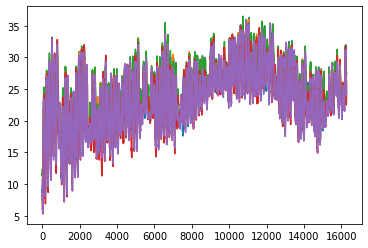

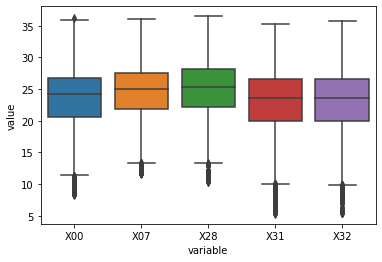

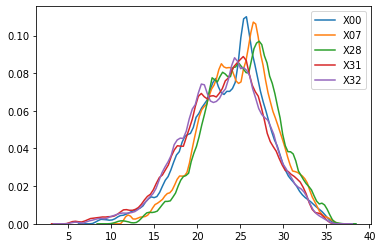

In [0]:
# 기온
show_plot(temperature_name)
kde_plot(temperature_name)

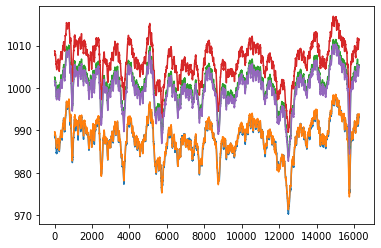

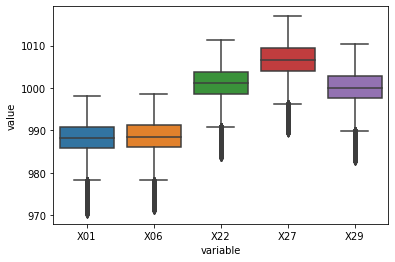

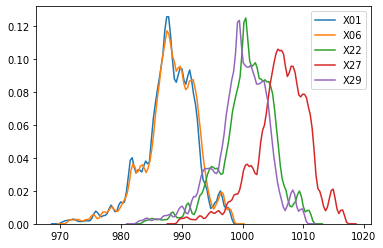

In [0]:
# 현지 기압
show_plot(localpress_name )
kde_plot(localpress_name )

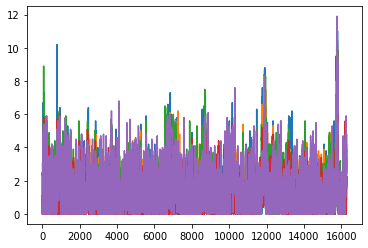

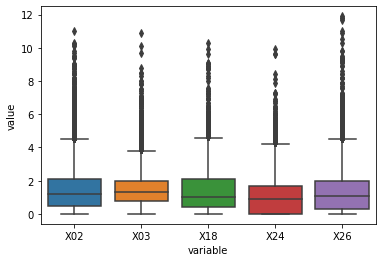

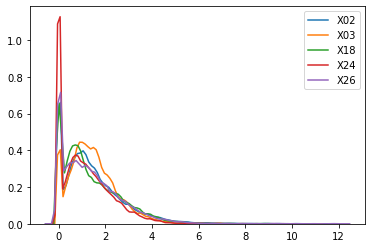

In [0]:
# 풍속
show_plot(speed_name)
kde_plot(speed_name)

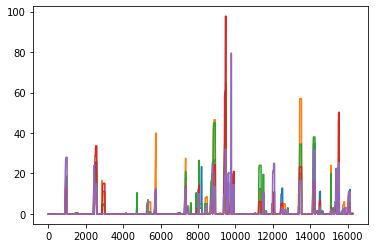

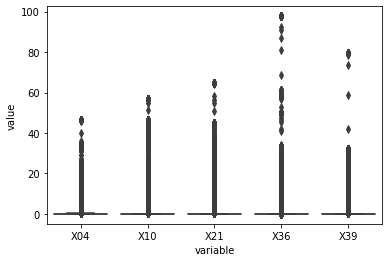

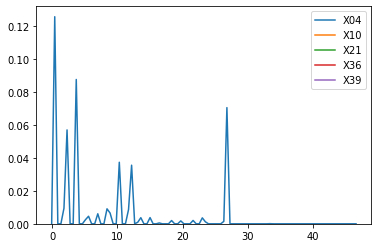

In [0]:
# 강수량
show_plot(water_name)
kde_plot(water_name)

In [0]:
import seaborn as sns


In [0]:
train2 = train0[:500]
train2

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.00,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.00,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.00,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.00,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.00,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.00,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.00,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.00,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.00,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.00,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,26.2,992.4,3.8,3.0,0.0,1011.6,992.3,26.9,1011.3,1012.0,0.0,7.51,43.8,74.9,0.0,109.0,0.0,182.3,2.3,0.0,44.9,0.0,1005.2,1011.9,0.4,93.0,2.1,1010.8,27.8,1004.1,37.9,27.2,28.6,1012.1,7.70,197.4,0.0,45.2,34.4,0.0,25.0,30.0,31.0,24.0,24.0,32.0,36.5,46.5,29.0,34.5,36.5,38.5,39.0,26.0,25.5,32.5,34.0,39.5,NaN
496,496,26.1,992.3,3.0,1.5,0.0,1011.5,992.3,27.5,1011.3,1012.0,0.0,8.02,42.8,71.9,0.0,108.5,0.0,157.6,2.9,0.0,44.0,0.0,1005.1,1011.9,2.0,138.1,1.9,1010.7,27.9,1004.1,35.7,26.6,28.3,1012.0,8.22,250.2,0.0,43.5,34.4,0.0,25.5,30.5,32.0,24.5,24.5,32.5,36.0,46.5,29.5,35.0,37.5,39.5,39.0,26.5,26.0,32.0,34.5,39.0,NaN
497,497,26.5,992.3,2.8,1.8,0.0,1011.4,992.3,27.6,1011.3,1012.0,0.0,8.55,40.2,58.3,0.0,107.5,0.0,164.4,2.5,0.0,43.0,0.0,1005.0,1011.9,2.3,120.1,2.7,1010.7,28.4,1004.1,35.3,27.1,28.2,1012.0,8.78,231.0,0.0,43.6,35.3,0.0,26.0,31.5,32.0,24.5,24.5,33.0,36.5,46.0,30.0,35.0,38.0,40.5,40.0,27.0,26.5,32.5,35.5,40.0,NaN
498,498,27.3,992.3,2.8,3.0,0.0,1011.5,992.2,28.0,1011.2,1011.9,0.0,9.09,36.4,30.7,0.0,96.9,0.0,143.9,0.8,0.0,43.4,0.0,1005.1,1011.9,2.1,94.0,2.5,1010.8,27.8,1004.1,34.5,27.4,28.9,1012.1,9.33,184.4,0.0,42.8,34.8,0.0,26.0,31.5,32.5,25.0,24.5,33.0,37.0,45.5,30.5,36.0,39.0,41.5,39.5,28.0,27.0,32.5,34.5,40.5,NaN


In [0]:
plt.figure(figsize=(18,4))
sns.pointplot(data=train2, x='id',y='X04')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fbcb97521e0> (for post_execute):


KeyError: ignored

KeyError: ignored

<Figure size 1296x288 with 1 Axes>

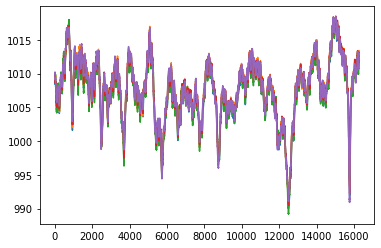

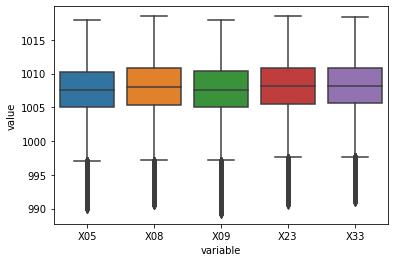

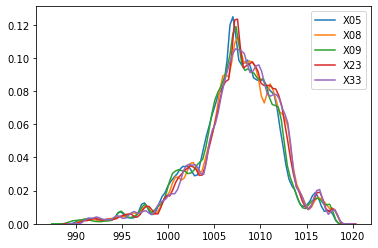

In [0]:
# 해면기압
show_plot(press_name)
kde_plot(press_name)

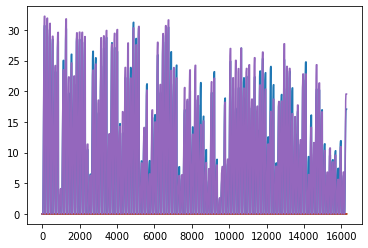

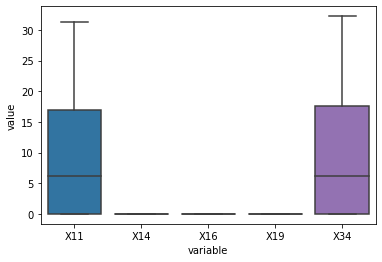

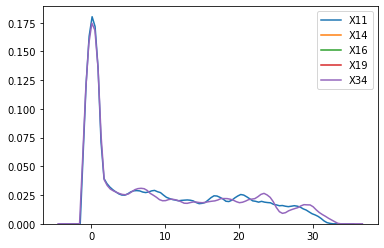

In [0]:
# 누적일사량
show_plot(sun_name)
kde_plot(sun_name)

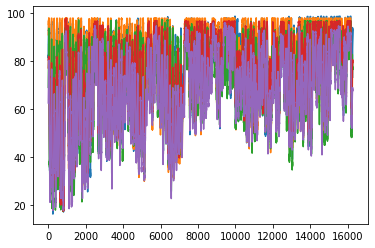

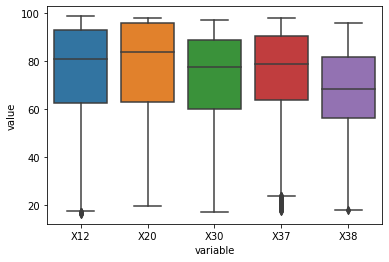

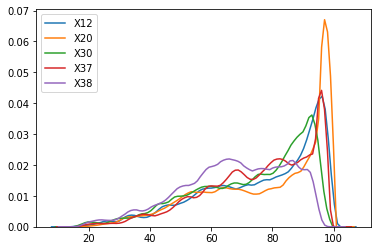

In [0]:
# 습도
show_plot(humidity_name)
kde_plot(humidity_name)

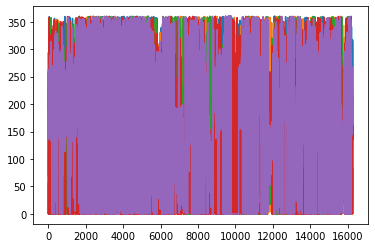

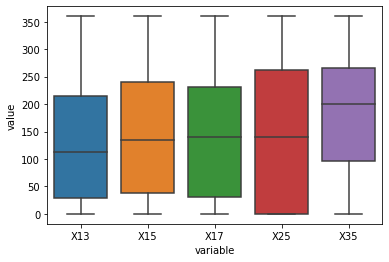

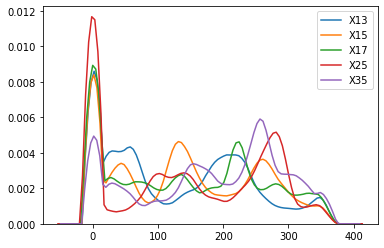

In [0]:
# 풍향
show_plot(direction_name)
kde_plot(direction_name)

## 주요 속성 살펴보기(Y00~Y18)


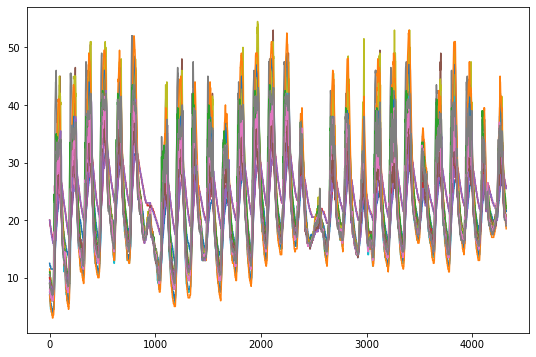

In [0]:
# Y00 ~ Y17 plot
col_y17 = []
for i in range(18):
    col_y17.append('Y{:02d}'.format(i))

plt.figure(figsize=(9, 6))
plt.plot(train[col_y17])
plt.show()

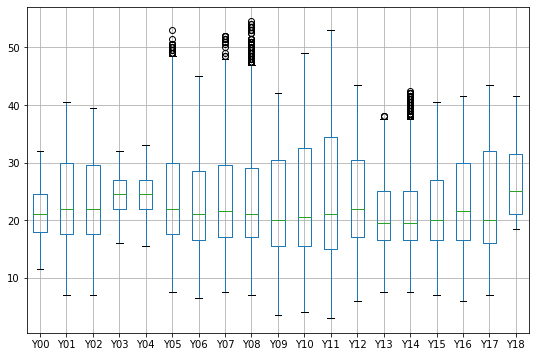

In [0]:
col_y18 = col_y17 + ['Y18']
plt.figure(figsize=(9, 6))
train[col_y18].boxplot()
plt.show()

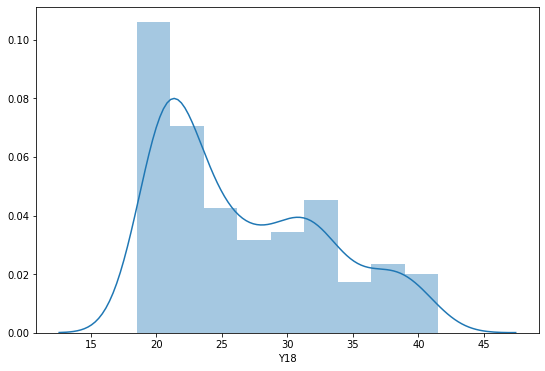

In [0]:
# Y18
plt.figure(figsize=(9, 6))
sns.distplot(train['Y18'])
plt.show()

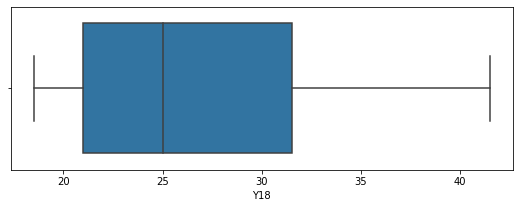

In [0]:
plt.figure(figsize=(9, 3))
sns.boxplot(train['Y18'])
plt.show()

## correlation 파악

### 전체 히트맵 그려보기


1.   X00~39와 Y00~17
2.   X00~39와 Y18
3.   각특성간 관계



In [0]:
train_for_heatmap = train.iloc[:,:-1]
train_for_heatmap = train_for_heatmap.dropna()
train_for_heatmap

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.00,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.00,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.00,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.00,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.00,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.00,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.00,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.00,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.00,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.00,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.5,987.8,1.7,0.4,0.0,1007.8,988.0,21.3,1007.8,1007.5,0.0,13.21,92.0,227.5,0.0,304.0,0.0,10.7,0.4,0.0,84.1,0.0,1001.2,1008.2,0.4,328.4,0.6,1006.6,21.6,1000.1,82.3,18.8,19.4,1008.2,16.68,272.9,0.0,82.3,74.3,0.0,22.0,22.5,22.5,26.0,26.0,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0
4316,19.3,987.7,2.1,0.9,0.0,1007.8,988.1,21.3,1008.0,1007.4,0.0,13.21,92.0,259.4,0.0,309.1,0.0,0.7,0.3,0.0,85.7,0.0,1001.2,1008.2,0.2,346.7,1.1,1006.8,21.6,1000.1,85.8,18.6,18.5,1008.4,16.68,315.9,0.0,82.4,74.8,0.0,22.0,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5
4317,19.5,987.8,0.9,1.3,0.0,1007.8,988.3,21.2,1008.1,1007.5,0.0,13.21,91.9,256.1,0.0,318.6,0.0,54.7,0.9,0.0,85.9,0.0,1001.2,1008.3,0.9,342.1,0.5,1006.8,21.5,1000.2,84.1,18.4,19.1,1008.4,16.68,343.3,0.0,82.8,75.4,0.0,21.5,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0


In [0]:
plt.rcParams['figure.figsize'] = [60,30]
correlations = train_for_heatmap.corr()

sns.heatmap(correlations, cmap = plt.cm.RdYlBu_r, vmin = 0.2, annot= True, vmax = 0.9)
plt.title('Correlation Heatmap')

Text(0.5, 1.0, 'Correlation Heatmap')

Error in callback <function flush_figures at 0x7fbcb94786a8> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
train_for_heatmap2 = train.iloc[4320:,0:40]
train_for_heatmap3 = train.iloc[:,-1]
train_for_heatmap3 = train_for_heatmap3.dropna()
train_for_heatmap_Y18 = pd.concat([train_for_heatmap2, train_for_heatmap3],axis = 1)

Text(0.5, 1.0, 'Correlation Heatmap Y18')

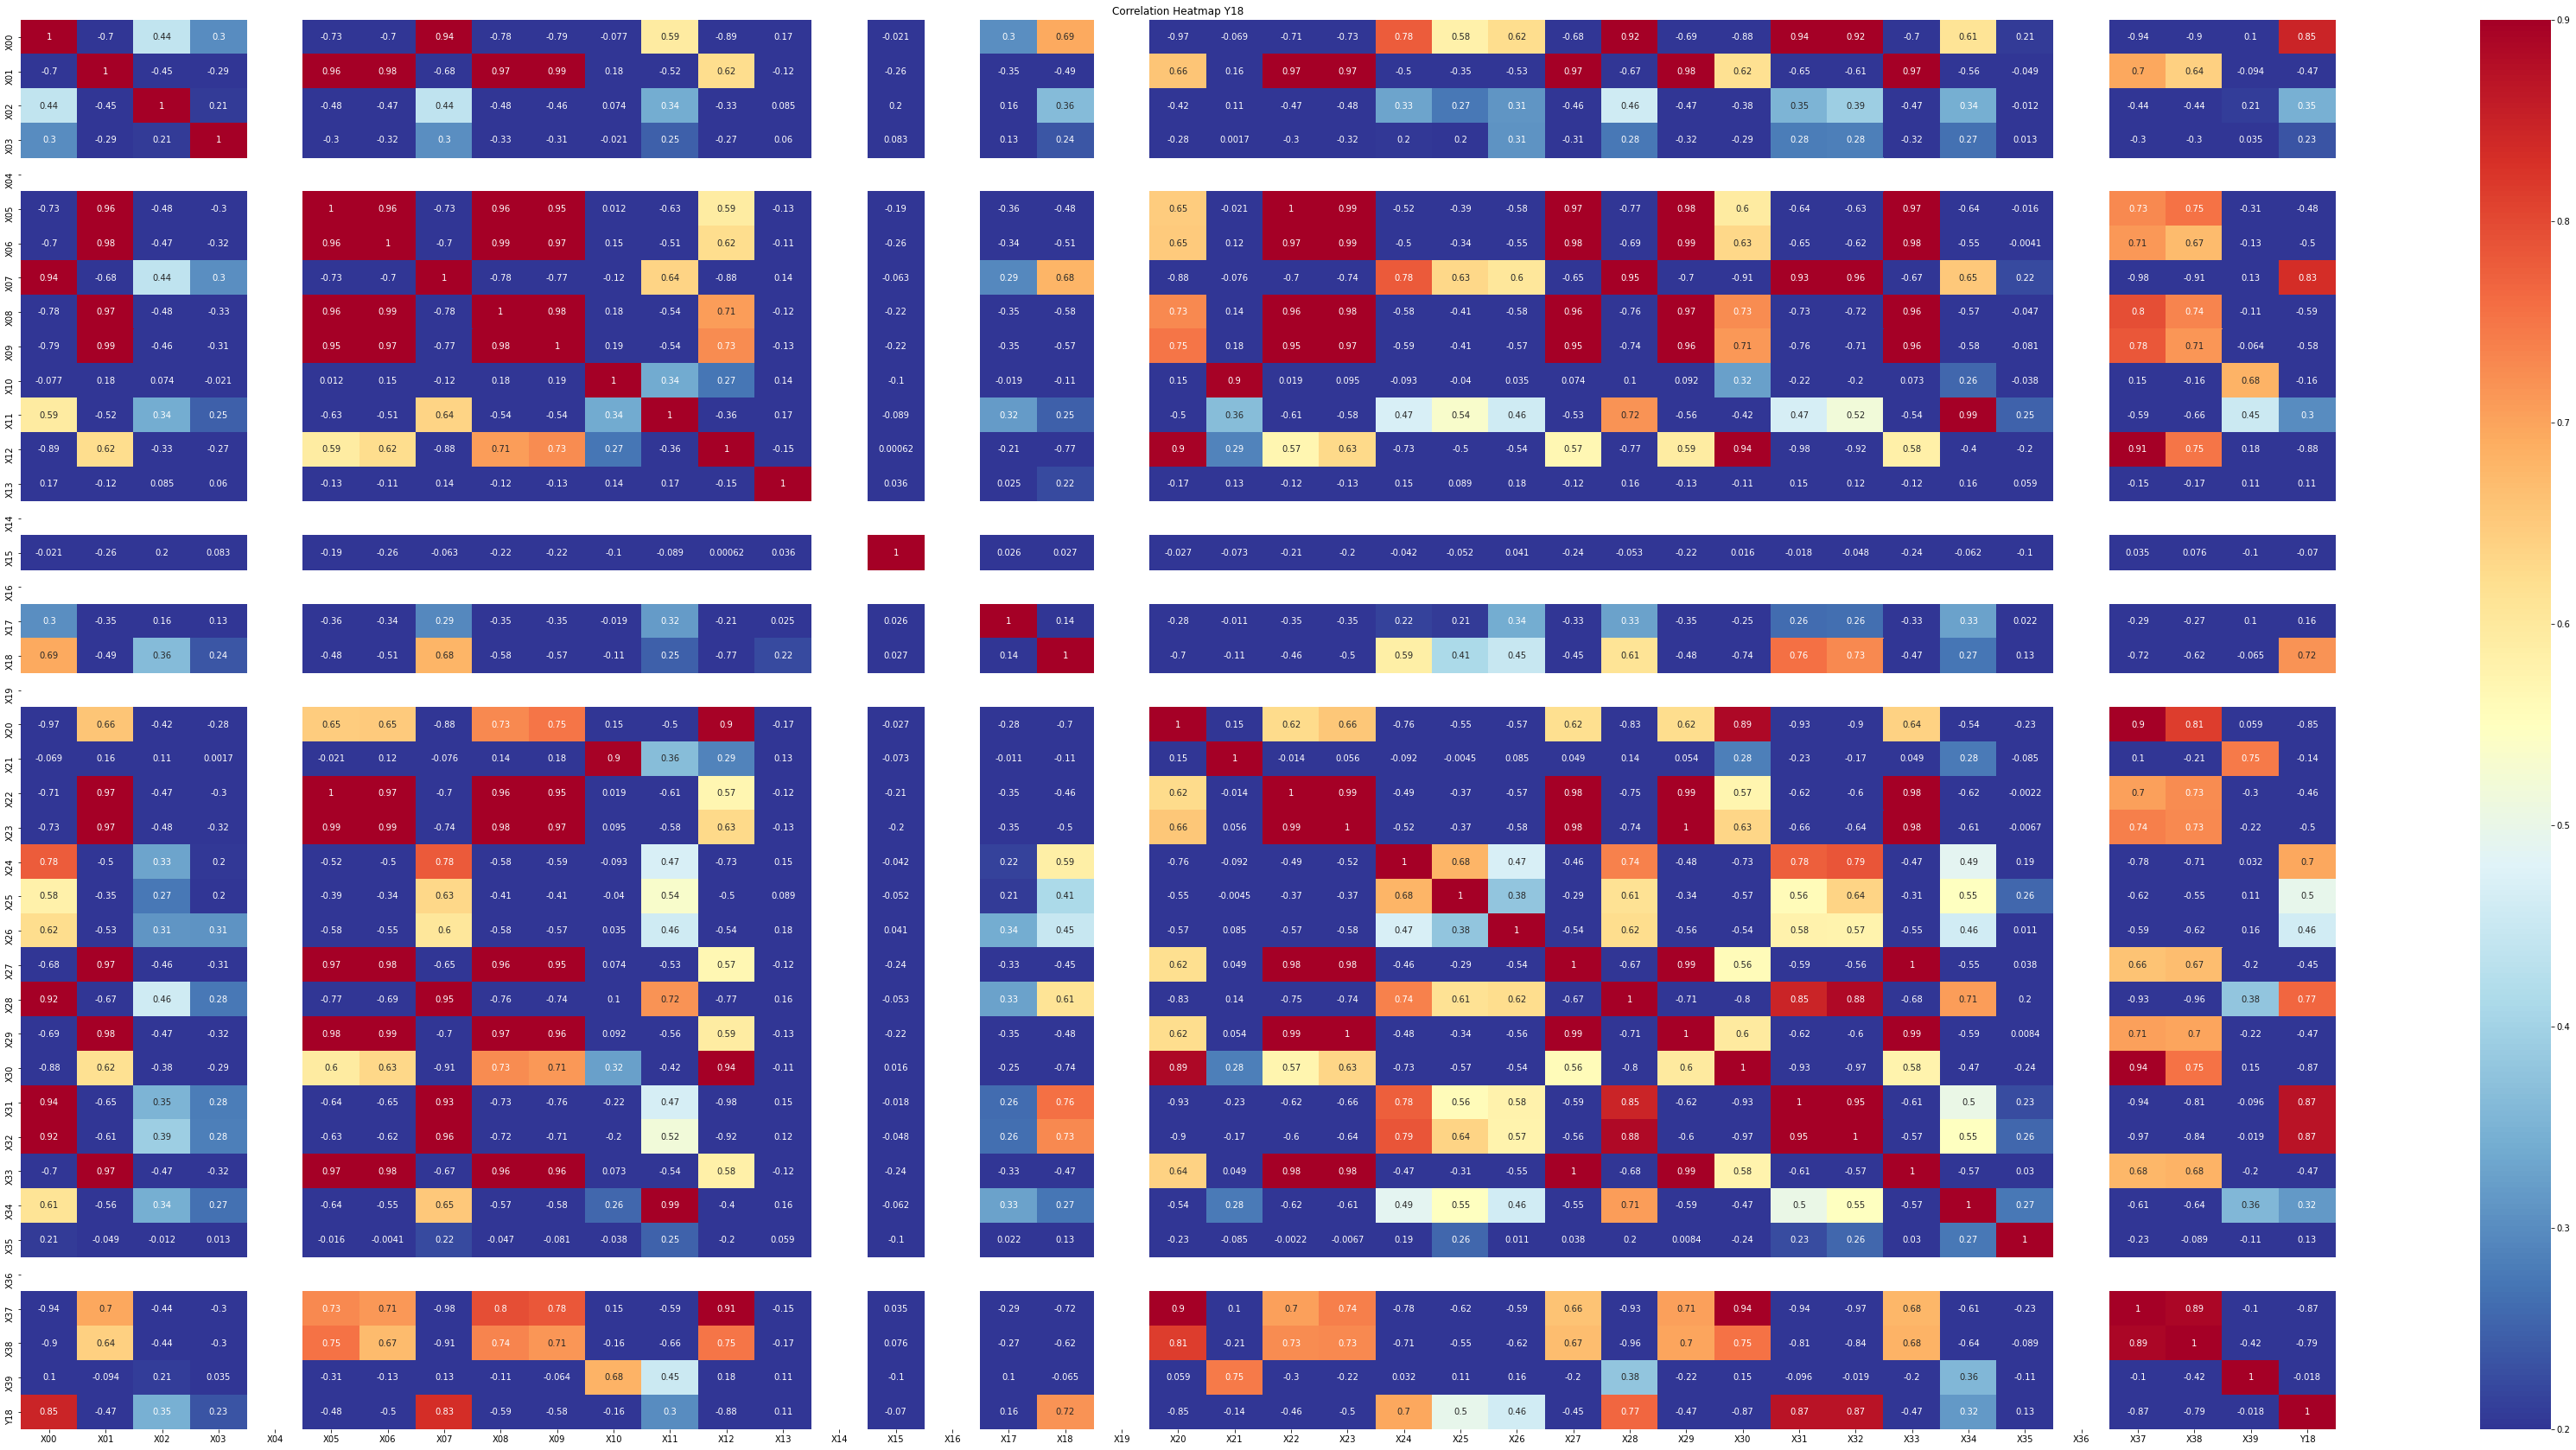

In [0]:
plt.rcParams['figure.figsize'] = [60,30]
correlations2 = train_for_heatmap_Y18.corr()

sns.heatmap(correlations2, cmap = plt.cm.RdYlBu_r, vmin = 0.2, annot= True, vmax = 0.9)
plt.title('Correlation Heatmap Y18')

In [0]:
# Y18과 관계없는 속성들
train.loc[:,['X04','X16','X19','X36']].T

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4712,4713,4714,4715,4716,4717,4718,4719,4720,4721,4722,4723,4724,4725,4726,4727,4728,4729,4730,4731,4732,4733,4734,4735,4736,4737,4738,4739,4740,4741,4742,4743,4744,4745,4746,4747,4748,4749,4750,4751
X04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Correlation Heatmap water')

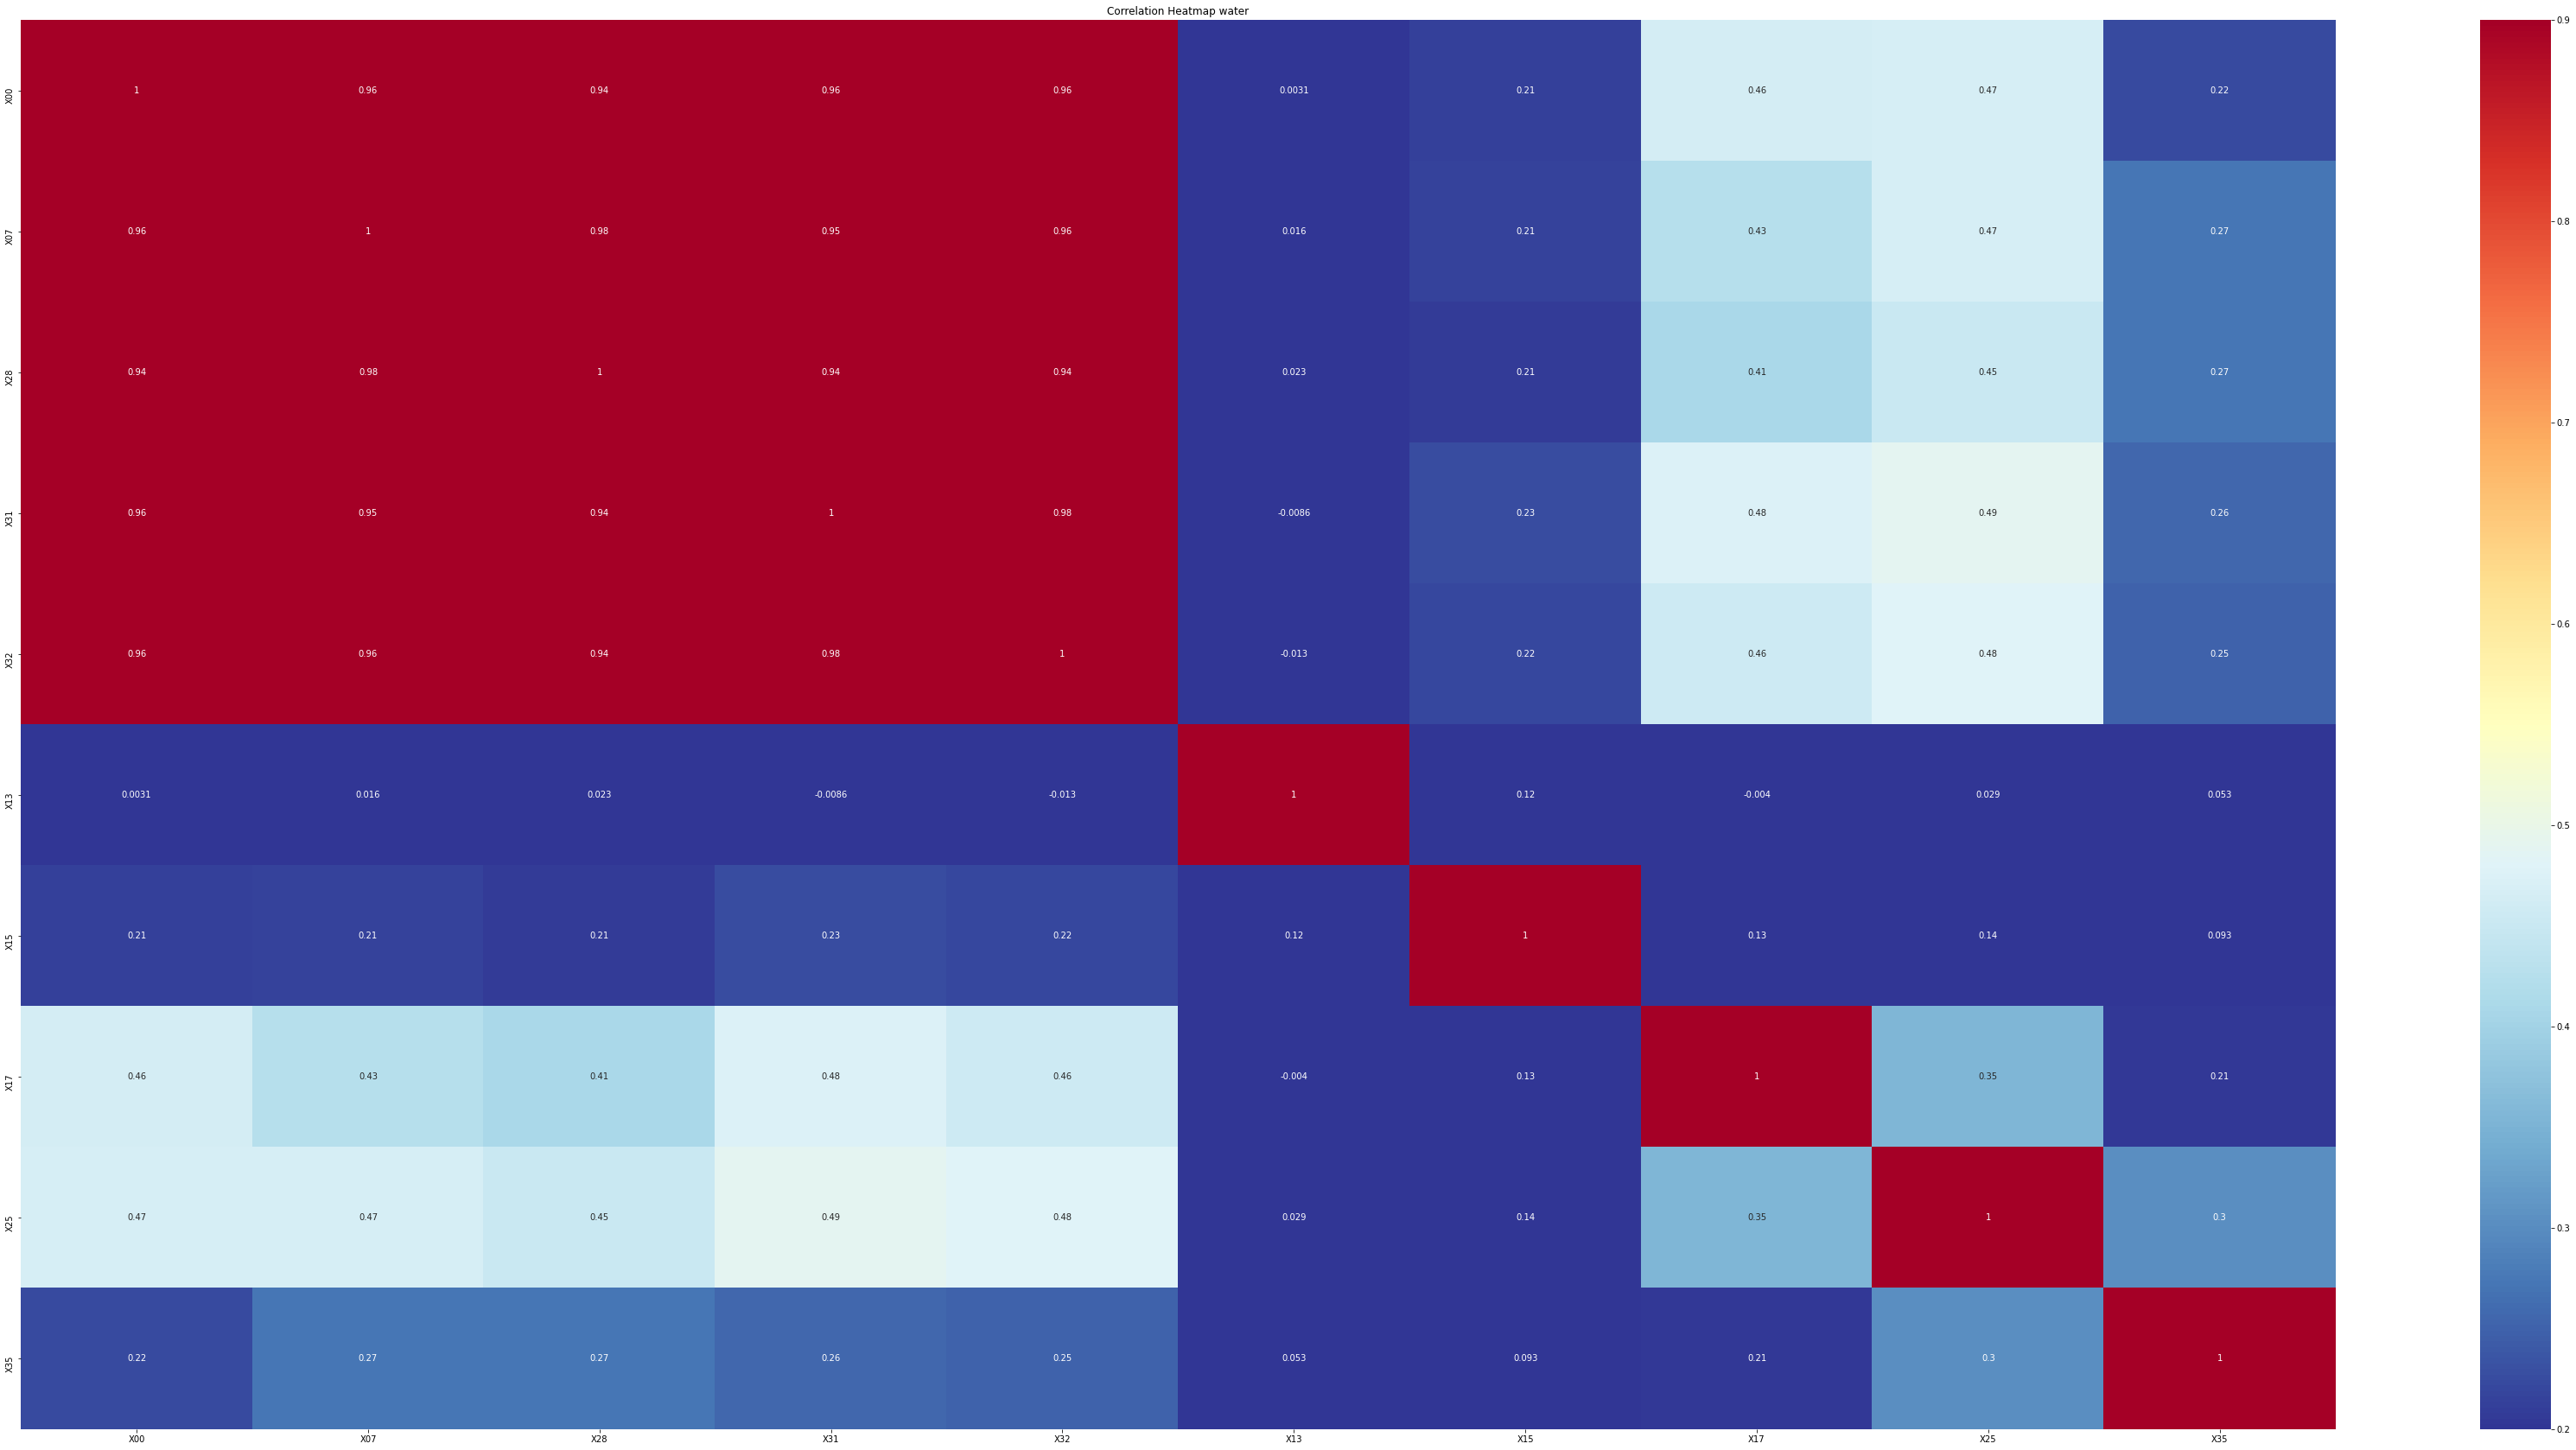

In [0]:
train_for_heatmap4 = train.loc[:,temperature_name]
train_for_heatmap5 = train.loc[:,direction_name]
train_for_heatmap_water = pd.concat([train_for_heatmap4, train_for_heatmap5],axis = 1)

plt.rcParams['figure.figsize'] = [60,30]
correlations_water = train_for_heatmap_water.corr()

sns.heatmap(correlations_water, cmap = plt.cm.RdYlBu_r, vmin = 0.2, annot= True, vmax = 0.9)
plt.title('Correlation Heatmap water')

### Y00~Y18 사이의 관계 파악하기


In [0]:
target = ['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08','Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18']
train[target].head()

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,
0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN


In [0]:
temp = train[train['Y18'].isnull()]
temp

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.00,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.00,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.00,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.00,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.00,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.00,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.00,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.00,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.00,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.00,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.5,987.8,1.7,0.4,0.0,1007.8,988.0,21.3,1007.8,1007.5,0.0,13.21,92.0,227.5,0.0,304.0,0.0,10.7,0.4,0.0,84.1,0.0,1001.2,1008.2,0.4,328.4,0.6,1006.6,21.6,1000.1,82.3,18.8,19.4,1008.2,16.68,272.9,0.0,82.3,74.3,0.0,22.0,22.5,22.5,26.0,26.0,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0,NaN
4316,19.3,987.7,2.1,0.9,0.0,1007.8,988.1,21.3,1008.0,1007.4,0.0,13.21,92.0,259.4,0.0,309.1,0.0,0.7,0.3,0.0,85.7,0.0,1001.2,1008.2,0.2,346.7,1.1,1006.8,21.6,1000.1,85.8,18.6,18.5,1008.4,16.68,315.9,0.0,82.4,74.8,0.0,22.0,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5,NaN
4317,19.5,987.8,0.9,1.3,0.0,1007.8,988.3,21.2,1008.1,1007.5,0.0,13.21,91.9,256.1,0.0,318.6,0.0,54.7,0.9,0.0,85.9,0.0,1001.2,1008.3,0.9,342.1,0.5,1006.8,21.5,1000.2,84.1,18.4,19.1,1008.4,16.68,343.3,0.0,82.8,75.4,0.0,21.5,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0,NaN


In [0]:
temp = train[~train['Y18'].isnull()]
temp

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4320,19.3,987.7,0.9,2.2,0.0,1007.7,988.0,20.8,1007.8,1007.4,0.0,0.00,93.2,162.5,0.0,312.8,0.0,0.0,0.5,0.0,87.0,0.0,1001.1,1008.2,1.1,257.5,0.0,1006.7,21.0,1000.1,87.6,18.0,18.7,1008.3,0.00,353.5,0.0,84.0,77.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4321,19.0,987.6,1.9,2.2,0.0,1007.7,988.0,20.6,1007.8,1007.4,0.0,0.00,93.7,317.4,0.0,308.9,0.0,0.0,0.1,0.0,89.2,0.0,1001.1,1008.2,0.4,262.5,0.1,1006.7,20.7,1000.1,86.4,17.7,19.0,1008.3,0.00,303.1,0.0,84.4,79.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4322,19.1,987.6,2.0,1.4,0.0,1007.8,988.1,20.5,1007.9,1007.4,0.0,0.00,93.6,0.0,0.0,294.1,0.0,0.0,0.0,0.0,89.2,0.0,1001.2,1008.2,0.1,343.5,0.0,1006.7,20.7,1000.1,85.7,17.4,19.2,1008.3,0.00,307.3,0.0,84.9,79.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4323,19.2,987.7,1.8,1.5,0.0,1007.9,988.1,20.5,1007.9,1007.5,0.0,0.00,93.7,0.0,0.0,297.6,0.0,0.0,0.0,0.0,89.8,0.0,1001.3,1008.2,0.0,0.0,0.0,1006.8,20.6,1000.1,85.1,17.5,19.3,1008.4,0.00,315.6,0.0,84.9,80.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4324,19.2,987.8,1.4,1.4,0.0,1007.9,988.1,20.5,1007.8,1007.6,0.0,0.00,93.9,0.0,0.0,277.4,0.0,0.0,0.0,0.0,89.7,0.0,1001.3,1008.3,0.0,0.0,0.0,1006.8,20.5,1000.2,84.9,17.4,19.5,1008.4,0.00,321.2,0.0,84.9,80.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,1007.4,2.5,23.88,95.3,333.1,0.0,274.9,0.0,275.5,0.9,0.0,89.7,10.5,1000.4,1007.5,0.0,0.0,1.2,1006.0,23.8,999.4,89.9,17.7,19.1,1007.5,22.16,218.6,0.0,82.3,58.6,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,1007.4,2.5,23.88,95.6,216.4,0.0,277.3,0.0,247.0,1.0,0.0,90.1,10.5,1000.3,1007.5,0.0,0.0,1.3,1006.0,23.6,999.4,91.3,17.7,19.2,1007.5,22.16,161.7,0.0,82.5,59.1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,1007.5,2.5,23.88,95.9,127.8,0.0,256.1,0.0,299.1,0.6,0.0,90.8,10.5,1000.4,1007.6,0.0,0.0,0.2,1006.0,23.6,999.5,90.2,17.8,19.2,1007.5,22.16,254.2,0.0,83.0,58.9,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


In [0]:
y18 = train[~train['Y18'].isnull()]['Y18'].reset_index(drop = True)
y18

0      20.5
1      20.5
2      20.5
3      20.5
4      20.5
       ... 
427    21.5
428    21.5
429    21.5
430    21.5
431    21.0
Name: Y18, Length: 432, dtype: float64

In [0]:
no_y18_target = ['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08','Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17']
no_y18 = train[(train['Y18'].isnull()) & (train.index > 3887)][no_y18_target].reset_index(drop=True)
no_y18

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17
0,20.5,20.5,20.5,25.5,25.5,19.5,18.5,19.0,19.5,17.5,18.5,17.5,18.5,18.0,17.5,17.0,18.5,17.0
1,20.0,20.5,20.5,25.5,25.5,19.5,18.5,19.0,19.5,17.0,18.0,17.5,18.5,17.5,17.5,17.0,18.0,17.0
2,20.0,20.0,20.5,25.5,25.5,19.5,18.0,19.0,19.0,17.0,18.0,17.0,18.5,17.5,17.5,17.0,18.0,17.0
3,20.0,20.0,20.0,25.5,25.0,19.5,18.0,19.0,19.0,17.0,18.0,17.0,18.5,17.0,17.0,17.0,18.0,16.5
4,19.5,20.0,20.0,25.0,25.0,19.5,18.0,18.5,19.0,17.0,17.5,17.0,18.0,17.0,17.0,17.0,18.0,16.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,22.0,22.5,22.5,26.0,26.0,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0
428,22.0,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5
429,21.5,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0
430,21.5,22.0,22.0,25.5,25.5,20.5,20.0,20.0,20.0,19.5,20.0,18.5,20.0,20.0,19.5,19.5,20.0,19.0


In [0]:
check_target = pd.concat([no_y18,y18],axis = 1)
check_target

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,20.5,20.5,20.5,25.5,25.5,19.5,18.5,19.0,19.5,17.5,18.5,17.5,18.5,18.0,17.5,17.0,18.5,17.0,20.5
1,20.0,20.5,20.5,25.5,25.5,19.5,18.5,19.0,19.5,17.0,18.0,17.5,18.5,17.5,17.5,17.0,18.0,17.0,20.5
2,20.0,20.0,20.5,25.5,25.5,19.5,18.0,19.0,19.0,17.0,18.0,17.0,18.5,17.5,17.5,17.0,18.0,17.0,20.5
3,20.0,20.0,20.0,25.5,25.0,19.5,18.0,19.0,19.0,17.0,18.0,17.0,18.5,17.0,17.0,17.0,18.0,16.5,20.5
4,19.5,20.0,20.0,25.0,25.0,19.5,18.0,18.5,19.0,17.0,17.5,17.0,18.0,17.0,17.0,17.0,18.0,16.5,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,22.0,22.5,22.5,26.0,26.0,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0,21.5
428,22.0,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5,21.5
429,21.5,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0,21.5
430,21.5,22.0,22.0,25.5,25.5,20.5,20.0,20.0,20.0,19.5,20.0,18.5,20.0,20.0,19.5,19.5,20.0,19.0,21.5


Text(0.5, 1.0, 'Correlation Heatmap Y00~17~18')

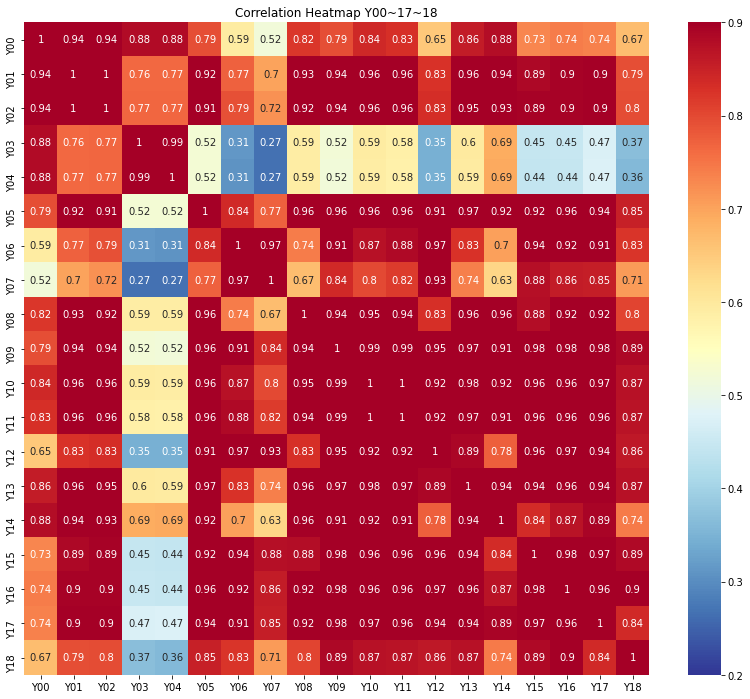

In [0]:
correlations3 = check_target.corr()
plt.rcParams['figure.figsize'] = [14,12]

sns.heatmap(correlations3, cmap = plt.cm.RdYlBu_r, vmin = 0.2, annot = True, vmax = 0.9)
plt.title('Correlation Heatmap Y00~17~18')

In [0]:
check_target.reset_index(inplace = True)
check_target

,index,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,20.5,20.5,20.5,25.5,25.5,19.5,18.5,19.0,19.5,17.5,18.5,17.5,18.5,18.0,17.5,17.0,18.5,17.0,20.5
1,1,20.0,20.5,20.5,25.5,25.5,19.5,18.5,19.0,19.5,17.0,18.0,17.5,18.5,17.5,17.5,17.0,18.0,17.0,20.5
2,2,20.0,20.0,20.5,25.5,25.5,19.5,18.0,19.0,19.0,17.0,18.0,17.0,18.5,17.5,17.5,17.0,18.0,17.0,20.5
3,3,20.0,20.0,20.0,25.5,25.0,19.5,18.0,19.0,19.0,17.0,18.0,17.0,18.5,17.0,17.0,17.0,18.0,16.5,20.5
4,4,19.5,20.0,20.0,25.0,25.0,19.5,18.0,18.5,19.0,17.0,17.5,17.0,18.0,17.0,17.0,17.0,18.0,16.5,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,427,22.0,22.5,22.5,26.0,26.0,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0,21.5
428,428,22.0,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5,21.5
429,429,21.5,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0,21.5
430,430,21.5,22.0,22.0,25.5,25.5,20.5,20.0,20.0,20.0,19.5,20.0,18.5,20.0,20.0,19.5,19.5,20.0,19.0,21.5


In [0]:
#인풋: 기준 컬럼이 속한 데이터프레임, 기준 컬럼, 기준 상관계수 
#아웃풋: 기준 컬럼과 상관계수가 기준 상관계수보다 높은 컬럼들의 이름

def high_corr(df, col, ratio):
    #Y에 대한 상관계수 데이터프레임 생성
    Y_corr = df.corr()
    Y_high = Y_corr.loc[:,Y_corr[col]> ratio].columns
    return Y_high.drop(col)

#인풋 생성: Y컬럼들
df = train.loc[:,"Y00":"Y17"]
#아웃풋 생성: Y17과 상관계수가 0.8 이상인 Y컬럼들
Y_high = high_corr(df, "Y17", 0.8)
print("Y17와 상관계수가 높은 Y컬럼들 ", Y_high.tolist())

#응용
#Y_high = high_corr(df, "Y18", 0.8)

Y17와 상관계수가 높은 Y컬럼들  ['Y01', 'Y02', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16']


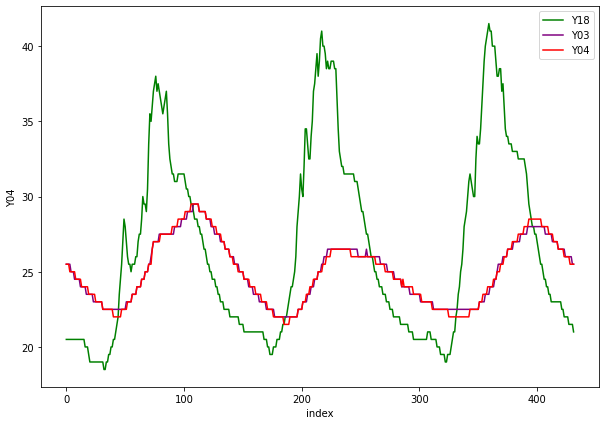

In [0]:
fig, ax = plt.subplots(figsize = (10,7))
sns.lineplot(data=check_target, x='index', y='Y18', color='green', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y03', color='purple', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y04', color='red', ax=ax)
plt.legend(['Y18', 'Y03', 'Y04'])
plt.show()

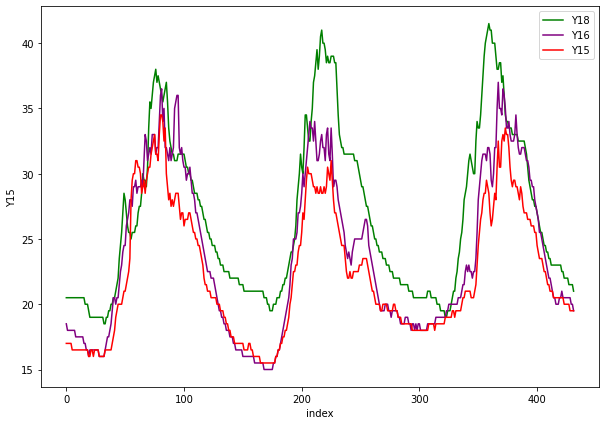

In [0]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(data=check_target, x='index', y='Y18', color='green', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y16', color='purple', ax=ax)
sns.lineplot(data=check_target, x='index', y='Y15', color='red', ax=ax)
plt.legend(['Y18', 'Y16', 'Y15'])
plt.show()

In [0]:
# 결론
#Y00~Y18을 종합하여 하나의 target attribute를 만들어야 한다.
#Y18이 우리가 실제로 예측해야 할 장소이다.
#Y03과 Y04는 Y18과 다른 양상을 띄고 있다.
#해당 장소들은 아예 삭제를 하고 분석을 진행하는 등의 어떠한 조치가 필요할 것으로 생각된다.

# Transfer Learning 기법 베이스 라인


## 1. 데이터 전처리

### 1-1 id 시간 변수 만들기


In [0]:
minute = (train.index%144).astype(int)
hour= pd.Series((train.index%144/6).astype(int))

In [0]:
min_in_day = 24*6
hour_in_day = 24

minute_sin = np.sin(np.pi*minute/min_in_day) 
minute_cos = np.cos(np.pi*minute/min_in_day)

hour_sin  = np.sin(np.pi*hour/hour_in_day)
hour_cos  = np.cos(np.pi*hour/hour_in_day)

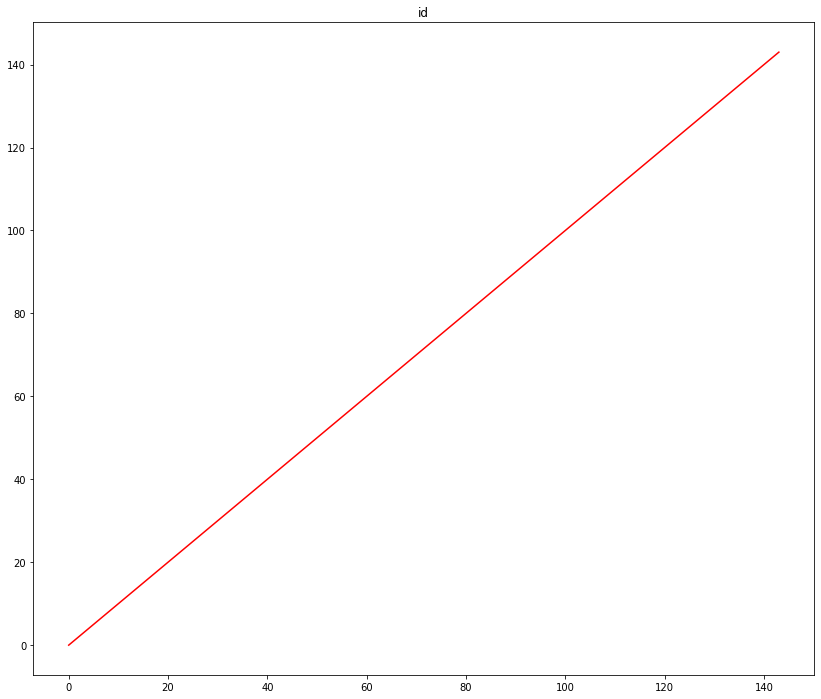

In [0]:
t1 = range(len(train.index[:144]))
plt.plot(t1, train.index[:144], 'r-')
plt.title("id")
plt.show()

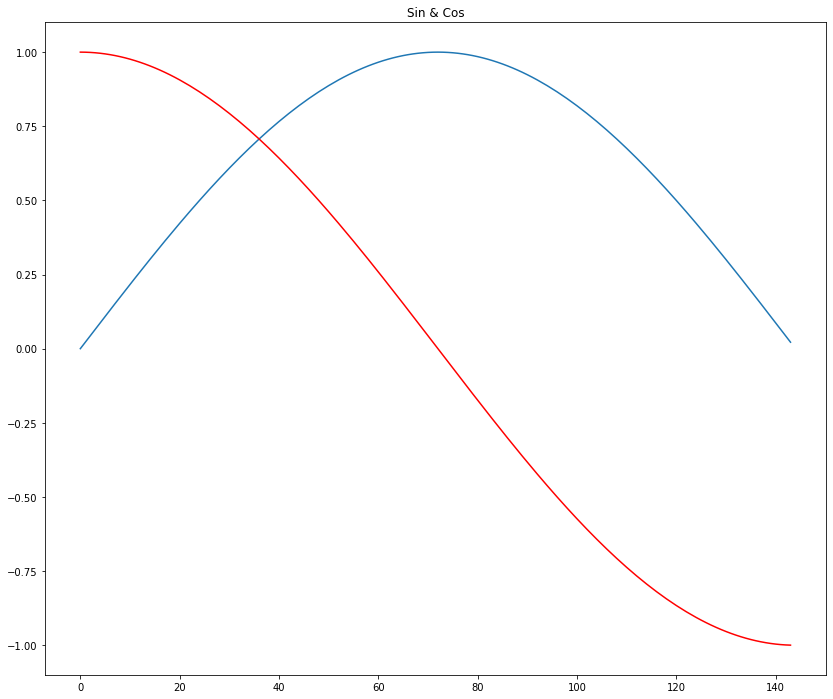

In [0]:
t1 = range(len(minute_sin[:144]))
plt.plot(t1, minute_sin[:144], 
         t1, minute_cos[:144], 'r-')
plt.title("Sin & Cos")
plt.show()

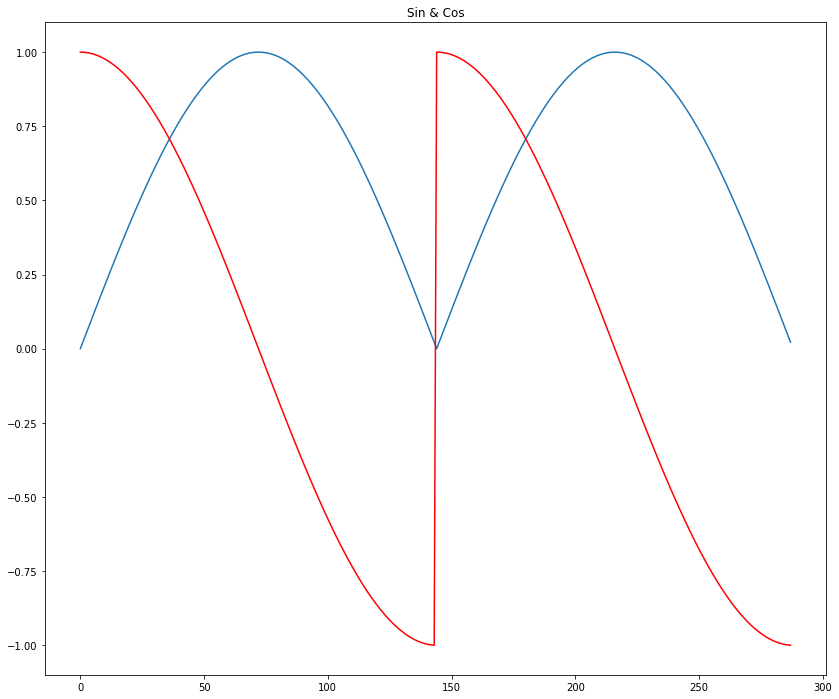

In [0]:
t1 = range(len(minute_sin[:288]))
plt.plot(t1, minute_sin[:288], 
         t1, minute_cos[:288], 'r-')
plt.title("Sin & Cos")
plt.show()

### 1-2 X특성 처리


In [0]:
X_train = train.loc[:,'X00':'X39'].copy()
X_test = test.copy()

In [0]:
# 제거된 특성은 일일 누적일사량, 모든 값이 0인 것으로 확인.
removedFeature = ['X14','X16','X19']
X_train.drop(removedFeature, axis = 1, inplace = True)
X_test.drop(removedFeature, axis=1, inplace=True)

In [0]:
# 남은 누적일사량 X11, X34는 분포가 같고, 값의 크기 차이가 적다. 평균내서 단일 특성으로 활용하자.
X_train['sun'] = X_train[['X11','X34']].mean(axis=1)
X_test['sun'] = X_test[['X11','X34']].mean(axis=1)
X_train.drop(['X11','X34'], axis=1, inplace=True)
X_test.drop(['X11','X34'], axis=1, inplace=True)

In [0]:
# 기온의 분포가 거의 같아서 평균 내어 temp 특성으로 사용
X_train['temp'] = X_train[temperature_name].mean(axis=1)
X_test['temp'] = X_test[temperature_name].mean(axis=1)
X_train.drop(temperature_name, axis=1, inplace=True)
X_test.drop(temperature_name, axis=1, inplace=True)

In [0]:
# 기압은 합치고 평균
X_train['press'] = X_train[press_sum_name].mean(axis=1)
X_test['press'] = X_test[press_sum_name].mean(axis=1)
X_train.drop(localpress_name, axis=1, inplace=True)
X_test.drop(localpress_name, axis=1, inplace=True)
X_train.drop(press_name, axis=1, inplace=True)
X_test.drop(press_name, axis=1, inplace=True)

In [0]:
# 풍향, 제거
X_train.drop(direction_name, axis=1, inplace=True)
X_test.drop(direction_name, axis=1, inplace=True)

In [0]:
#강수량 max
X_train['water'] = X_train['X39']
X_test['water'] =  X_test['X39']
X_train.drop(water_name, axis=1, inplace=True)
X_test.drop(water_name, axis=1, inplace=True)

In [0]:
X_train

,X02,X03,X12,X18,X20,X24,X26,X30,X37,X38,sun,temp,press,water
id,,,,,,,,,,,,,,
0,1.2,0.6,82.4,0.3,91.0,1.1,0.5,69.1,77.2,62.6,0.00,10.62,1004.01,0.0
1,1.7,1.9,81.2,0.4,91.9,0.0,0.0,70.3,77.3,63.5,0.00,10.42,1004.06,0.0
2,1.1,2.3,86.1,0.6,93.3,0.0,0.0,71.5,77.3,63.9,0.00,10.26,1004.05,0.0
3,1.5,0.7,87.7,0.1,93.4,0.0,0.2,73.2,77.5,64.5,0.00,10.12,1004.01,0.0
4,0.8,1.7,88.9,0.0,94.1,0.0,0.0,74.3,78.0,65.0,0.00,10.00,1004.03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,0.9,0.8,95.3,0.9,89.7,0.0,1.2,89.9,82.3,58.6,23.02,20.44,1001.79,0.5
4748,0.5,0.7,95.6,1.0,90.1,0.0,1.3,91.3,82.5,59.1,23.02,20.40,1001.77,0.5
4749,0.9,0.6,95.9,0.6,90.8,0.0,0.2,90.2,83.0,58.9,23.02,20.34,1001.81,0.5


### 1-3 input 데이터 처리



In [0]:
# 표준화처리
def standardization(df):
    mean = np.mean(df)
    std = np.std(df)
    norm = (df - mean) / (std + 1e-07)
    return norm, mean, std

In [0]:
#minmax
def Minmax(X):
  x_scaler = MinMaxScaler()
  for col_ in X.columns:
    train_scaled = x_scaler.fit_transform(X[col_][:, np.newaxis])
    X[col_] = train_scaled.flatten()
  return X


In [0]:
X_train_norm, MEAN, STD = standardization(X_train) 
#X_train_norm = Minmax(X_train)

In [0]:
# RNN 모델에 입력 할 수 있는 시계열 형태로 데이터 변환 
def convert_to_timeseries(df, interval):
  sequence_list = []
  target_list = []

  for i in tqdm(range(df.shape[0] - interval)):
    sequence_list.append(np.array(df.iloc[i:i+interval,:-1]))
    target_list.append(df.iloc[i+interval,-1])

  sequence = np.array(sequence_list)
  target = np.array(target_list)

  return sequence, target

In [0]:
y_columns = ['Y15','Y16'] #'Y15','Y16'

In [0]:
# t시점 이전 120분의 데이터로 t시점의 온도를 추정할 수 있는 학습데이터 형성
sequence = np.empty((0,12,len(X_train_norm.columns)))
target = np.empty((0,))

for column in y_columns:

  concat = pd.concat([X_train_norm, train[column]], axis =1) #train[column]

  _sequence, _target = convert_to_timeseries(concat.head(144*30), interval = 12)
  # 24시간 = 1440분 = 144* 10분 즉, 30일 

  sequence = np.vstack((sequence, _sequence))
  target = np.hstack((target,_target))



100%|██████████| 4308/4308 [00:01<00:00, 2690.80it/s]


In [0]:
# convert_to_timeseries 함수를 쓰기 위한 dummy feature 생성
X_train_norm['dummy'] = 0

In [0]:
# train set에서 도출된 평균과 표준편차로 standardization 실시 
X_test_norm = (X_test - MEAN) / (STD + 1e-07) 
#X_test_norm = Minmax(X_test)

In [0]:
X_test_norm['dummy'] = 0

In [0]:
# train과 test 기간을 합쳐서 120분 간격으로 학습데이터 재구축
X_test_ts, _ = convert_to_timeseries(pd.concat([X_train_norm,X_test_norm],axis = 0 ), interval = 12)


100%|██████████| 16260/16260 [00:07<00:00, 2192.64it/s]


In [0]:
# test set 기간인 후반부 80일에 맞게 자르기 
X_test_ts = X_test_ts[-11520:,:,:]

In [0]:
X_test_ts.shape

(11520, 12, 14)

In [0]:
# 만들어 두었던 dummy feature 제거
X_train_norm.drop('dummy',axis=1, inplace = True)
X_test_norm.drop('dummy', axis = 1 ,inplace=True)

## 2. 탐색적 자료분석

## 3. 변수 선택 및 모델 구축 

In [0]:
def mse_keras(y_true, y_pred):
  def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

  score = tf.py_function(func=mse_AIFrenz, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') # tf 2.x
  return score

In [0]:
# 간단한 lstm 모델 구축하기
def build_model(lr):
  lstm_model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(128, input_shape=sequence.shape[-2:]),
      tf.keras.layers.Dense(256, activation='linear'),
      tf.keras.layers.Dense(128, activation='linear'),
      tf.keras.layers.Dense(1)
  ])
  
  # opt = tf.keras.optimizers.RMSprop(lr)
  opt = tf.keras.optimizers.Adam(lr)
  
  lstm_model.compile(optimizer=opt, loss='mse', metrics=[mse_keras])

  return lstm_model

LEARNINGRATE = 0.001
lstm_model = build_model(LEARNINGRATE)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               73216     
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 139,265
Trainable params: 139,265
Non-trainable params: 0
_________________________________________________________________


## 4.모델 학습 및 검증


In [0]:
# loss가 4미만으로 떨어지면 학습 종료 시키는 기능
# 전이 학습을 위해 느슨한 학습을 적용
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if(logs.get('loss') < 3):
            print('\n Loss is under 3, cancelling training')
            self.model.stop_training = True

In [0]:
callbacks = myCallback()

In [0]:
#X_train_T, X_valid, y_train_T, y_valid = train_test_split(sequence,target,test_size = 0.3, random_state = 0)
                                                            

In [0]:
#print(X_train_T.shape, X_train_T.dtype)
#print(X_valid.shape, X_valid.dtype)
#print(y_train_T.shape, y_train_T.dtype)
#print(y_valid.shape, y_valid.dtype)

In [0]:
# 모델 학습
score_list = []

lstm_model.fit(    
     sequence,target, # X_train_T, y_train_T, #
    epochs=100,
    batch_size=128,
    verbose=2,
    shuffle=False,
    callbacks = [callbacks]
)
#score = lstm_model.evaluate(X_valid, y_valid, batch_size=128)
#score_list.append(score)

## Part4. 평균내서 정확도 확인
#print('-'*50); print('score:',score_list)
#np.array(score_list)[:,1].mean()

Epoch 1/100
68/68 - 0s - loss: 153.1173 - mse_keras: 153.0903
Epoch 2/100
68/68 - 0s - loss: 12.5415 - mse_keras: 12.4589
Epoch 3/100
68/68 - 0s - loss: 8.4467 - mse_keras: 8.3438
Epoch 4/100
68/68 - 0s - loss: 6.8160 - mse_keras: 6.7007
Epoch 5/100
68/68 - 0s - loss: 5.9757 - mse_keras: 5.8589
Epoch 6/100
68/68 - 0s - loss: 5.5763 - mse_keras: 5.4545
Epoch 7/100
68/68 - 0s - loss: 5.2900 - mse_keras: 5.1726
Epoch 8/100
68/68 - 0s - loss: 4.9049 - mse_keras: 4.7804
Epoch 9/100
68/68 - 0s - loss: 4.9468 - mse_keras: 4.8213
Epoch 10/100
68/68 - 0s - loss: 4.9696 - mse_keras: 4.8468
Epoch 11/100
68/68 - 0s - loss: 4.9103 - mse_keras: 4.7882
Epoch 12/100
68/68 - 0s - loss: 5.1950 - mse_keras: 5.0741
Epoch 13/100
68/68 - 0s - loss: 5.5530 - mse_keras: 5.4443
Epoch 14/100
68/68 - 0s - loss: 6.1353 - mse_keras: 6.0211
Epoch 15/100
68/68 - 0s - loss: 7.0405 - mse_keras: 6.9359
Epoch 16/100
68/68 - 0s - loss: 8.1299 - mse_keras: 8.0383
Epoch 17/100
68/68 - 0s - loss: 12.1931 - mse_keras: 12.114

In [0]:
# LSTM 레이어는 고정
lstm_model.layers[0].trainalbe = False

In [0]:
# fine tuning 할 때 사용할 학습데이터 생성 (Y18)
finetune_X, finetune_y = convert_to_timeseries(pd.concat([X_train_norm.tail(432), train['Y18'].tail(432)],axis = 1),interval = 12)

100%|██████████| 420/420 [00:00<00:00, 1698.14it/s]


In [0]:
ftrain_XT, fvalid_XT, ftrain_yT, fvalid_yT = train_test_split(finetune_X,finetune_y,test_size = 0.3, random_state = 0)
                                                            

In [0]:
# LSTM 레이어는 고정 시켜두고, DNN 레이어에 대해서 fine tuning 진행 (Transfer Learning
score_list = []

finetune_history = lstm_model.fit(
            ftrain_XT, ftrain_yT,#finetune_X, finetune_y, #
            epochs=100,
            batch_size=256,
            shuffle=False,
            verbose = 2)#,
            #callbacks = callbacks2)
score = lstm_model.evaluate(fvalid_XT, fvalid_yT, batch_size=128)
score_list.append(score)
## Part4. 평균내서 정확도 확인
print('-'*50); print('score:',score_list)
np.array(score_list)[:,1].mean()

Epoch 1/100
2/2 - 0s - loss: 15.0354 - mse_keras: 14.9975
Epoch 2/100
2/2 - 0s - loss: 10.0371 - mse_keras: 9.9434
Epoch 3/100
2/2 - 0s - loss: 8.5984 - mse_keras: 8.4897
Epoch 4/100
2/2 - 0s - loss: 8.9626 - mse_keras: 8.8239
Epoch 5/100
2/2 - 0s - loss: 7.2059 - mse_keras: 7.0598
Epoch 6/100
2/2 - 0s - loss: 5.7239 - mse_keras: 5.6505
Epoch 7/100
2/2 - 0s - loss: 5.9174 - mse_keras: 5.8236
Epoch 8/100
2/2 - 0s - loss: 5.7899 - mse_keras: 5.6851
Epoch 9/100
2/2 - 0s - loss: 4.9126 - mse_keras: 4.7807
Epoch 10/100
2/2 - 0s - loss: 4.5241 - mse_keras: 4.4194
Epoch 11/100
2/2 - 0s - loss: 4.5323 - mse_keras: 4.4111
Epoch 12/100
2/2 - 0s - loss: 4.0681 - mse_keras: 3.9679
Epoch 13/100
2/2 - 0s - loss: 3.4903 - mse_keras: 3.3201
Epoch 14/100
2/2 - 0s - loss: 3.3169 - mse_keras: 3.1344
Epoch 15/100
2/2 - 0s - loss: 3.1979 - mse_keras: 3.0590
Epoch 16/100
2/2 - 0s - loss: 2.8945 - mse_keras: 2.7182
Epoch 17/100
2/2 - 0s - loss: 2.6685 - mse_keras: 2.4924
Epoch 18/100
2/2 - 0s - loss: 2.5824 

0.6230342984199524

In [0]:
# 예측하기
finetune_pred = lstm_model.predict(X_test_ts)

# 그래프 그리기


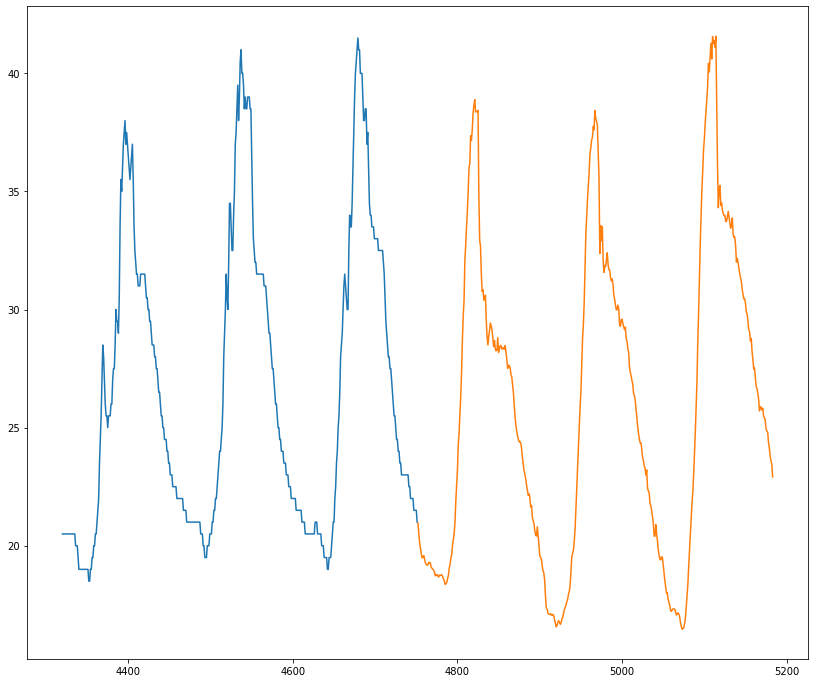

In [0]:
# Y18(3일) - Y18(3일예측)
ff=finetune_pred.flatten()
ff= ff[:432]
t1 = np.arange(4752,5184,1)
plt.plot(train.loc[-432:,'Y18'])
plt.plot(t1,ff)

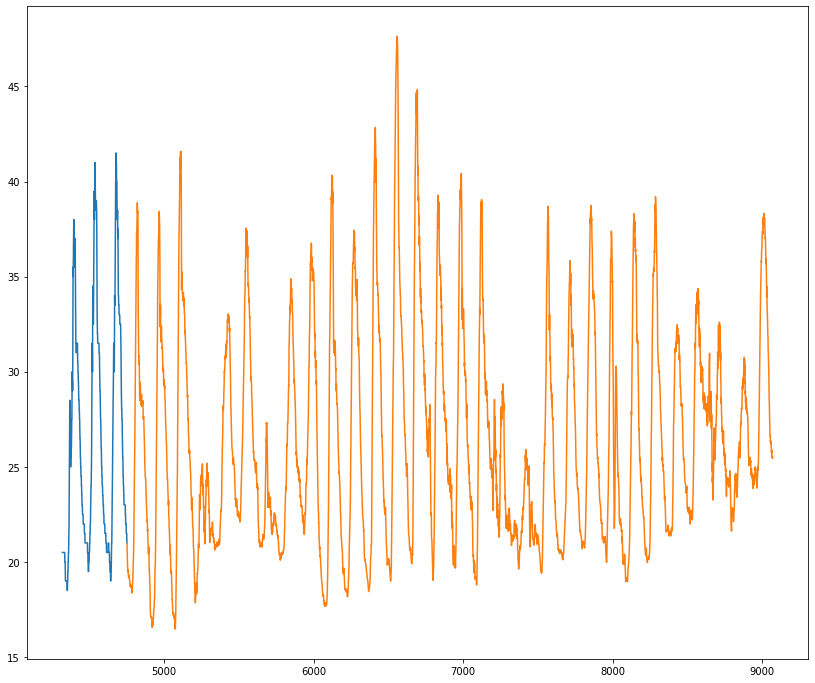

In [0]:
# Y18(3일) - Y18(30일예측)
ff=finetune_pred.flatten()
ff = ff[:4320]
t2 = np.arange(4752,9072,1)
plt.plot(train.loc[-432:,'Y18'])
plt.plot(t2,ff)

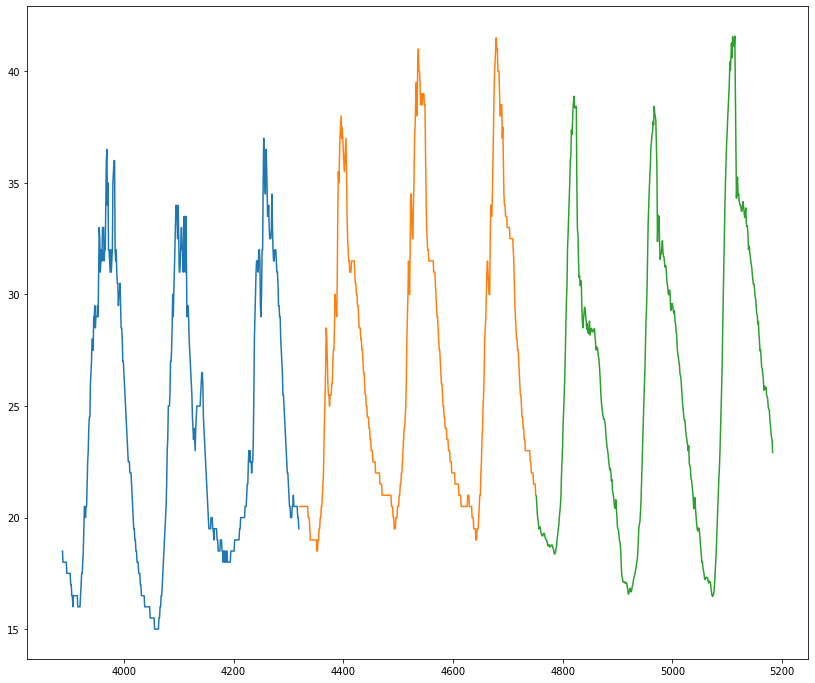

In [0]:
# Y16(3일)- Y18(3일)- Y18예측(3일)
ff= ff[:432]
plt.plot(train.loc[3888:4320,'Y16'])
plt.plot(train.loc[4320:4752,'Y18'])
plt.plot(t1,ff)

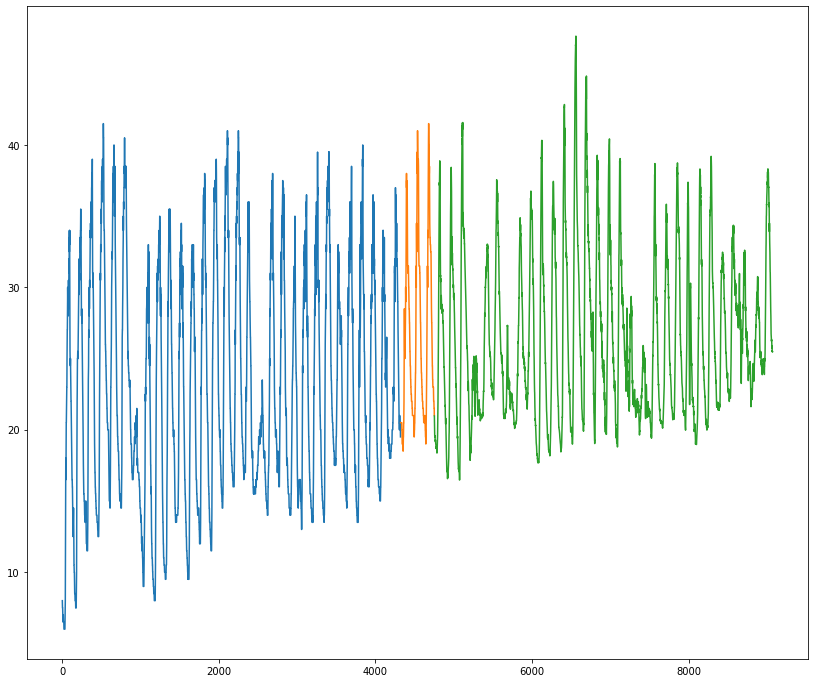

In [0]:
#Y16(30일) - Y18(3일) -  예측(30일)
ff=finetune_pred.flatten()
ff= ff[:4320]
plt.plot(train.loc[:4320,'Y16'])
plt.plot(train.loc[4320:4752,'Y18'])
plt.plot(t2,ff)

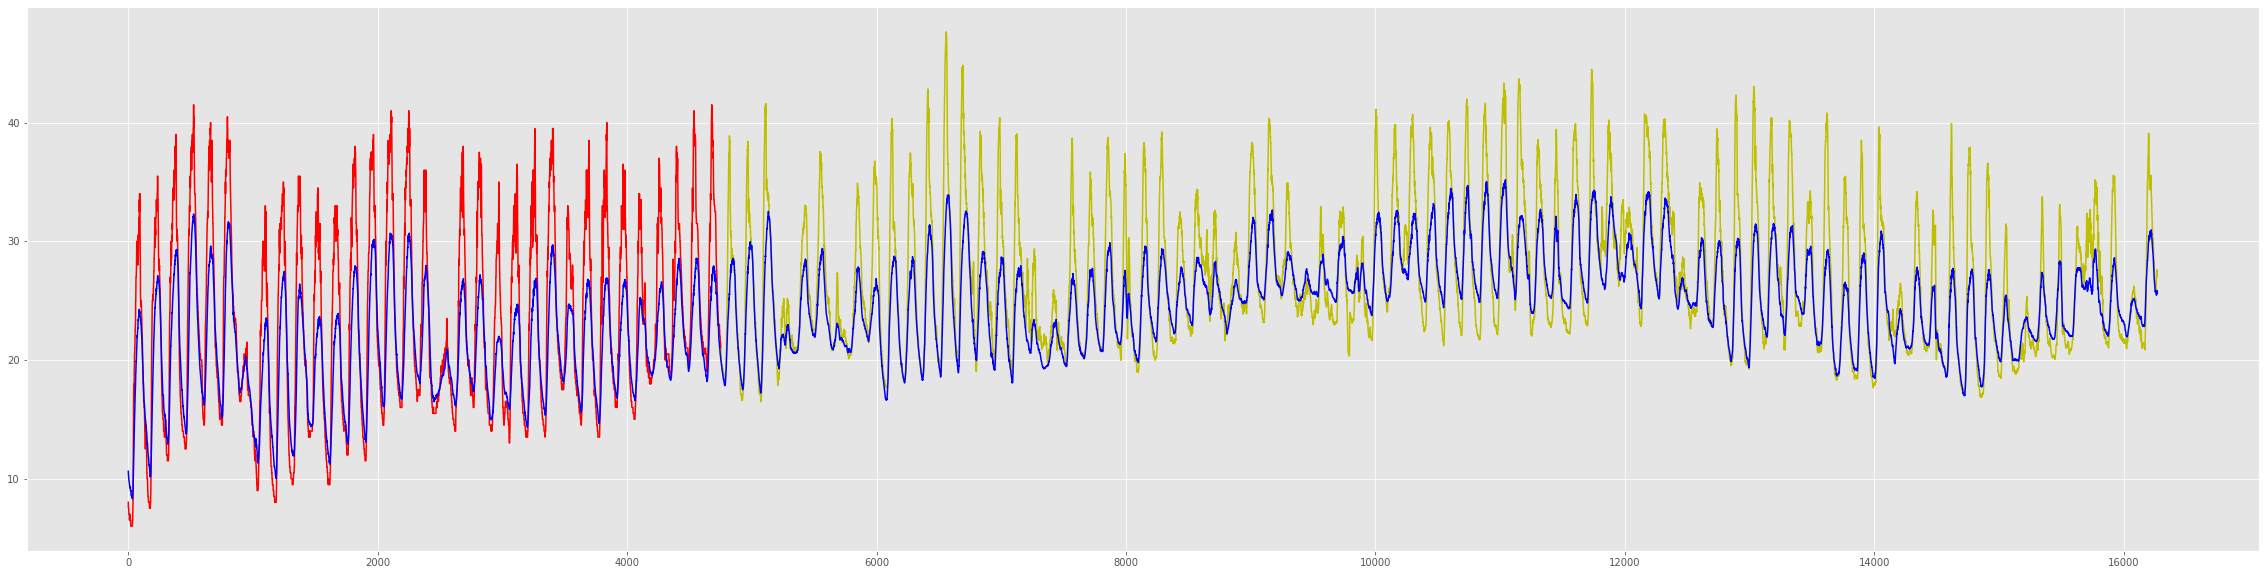

In [0]:
ff=finetune_pred.flatten()
style.use('ggplot')
t3 = np.arange(4752,16272,1)
temp_all = pd.concat([X_train.loc[:,'temp'] ,X_test.loc[:,'temp']], axis =0)
#temp_all = pd.concat([X_train.loc[:,'temp'] ,X_test.loc[:,'temp']], axis =0)
now = pd.concat([train.loc[:4320,'Y16'],train.loc[4320:4752,'Y18']],axis =0)

# red - y16(30) + y18(3), yellow - 예측, blue - X temp 데이터
plt.figure(figsize = (40,10))
plt.plot(now,'r')
plt.plot(t3,ff, 'y')
plt.plot(temp_all,'b')

## 6. 결과 및 결언

In [0]:
# 제출 파일 만들기
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':finetune_pred.reshape(1,-1)[0]})

In [0]:
submit.to_csv('baseline_result.021.csv', index = False)